## Generate graph data
Notebook consists of 2 stages:
1. Generate examples of random graphs and save to file
2. Generate features from the graphs and save features to a file

In [1]:
%reload_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
from spice_net import *
from helpers import *
import matplotlib.pyplot as plt
from analytic import *

### 1. Generate Random Graphs

In [38]:
# Fixed parameters
BIG_NUM = 1000
nodes = 9
edge_prob = .5

in_nodes = 2
out_nodes = 1

num_trials = 50000

boundary_tol = 0.15

featurize = True

In [39]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

In [40]:
slope_vals = []
intercept_vals = []

inside_nets = []
on_nets = []
outside_nets = []

coeff = np.linalg.inv(xs_bias.T @ xs_bias) @ xs_bias.T

X = []
X_feat = []
y = []

In [42]:
np.random.seed(0)
for _ in range(num_trials):
    con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
    for i, (u, v) in enumerate(con_graph.edges()):
        con_graph[u][v]['type'] = 'resistor'

    node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
    node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
    node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

    out_plus = node_cfg[1][0][0]
    out_minus = node_cfg[1][0][1]

    weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

    for i, (u, v) in enumerate(con_graph.edges()):
        con_graph[u][v]['weight'] = weights[i] # weights represent the resistance
        con_graph[u][v]['conductance'] = 1./weights[i] 

    net = LinearNetwork('test', con_graph, node_cfg)

    A = gen_A(net, net.inputs)
    sol = solve(A, xs_bias.T)
    sol_plus = sol[out_plus-1] if out_plus > 0 else np.zeros(sol[out_plus].shape)
    sol_minus = sol[out_minus-1] if out_minus > 0 else np.zeros(sol[out_minus].shape)
    preds = sol_plus - sol_minus

    # preds = net.predict(xs_bias).squeeze()

    slope, intercept = coeff @ preds

    if abs(slope) + abs(intercept) > 1 + boundary_tol:
        outside_nets.append((net.copy('special'), slope, intercept))
    elif abs(slope) + abs(intercept) > 1:
        on_nets.append((net.copy('special'), slope, intercept))
    elif len(inside_nets) < 10:
        inside_nets.append((net.copy('nonspecial'), slope, intercept))

    slope_vals.append(slope)
    intercept_vals.append(intercept)

    sources = net.inputs + net.outputs

    # create and save handpicked features
    features = []
    input_pins = np.array(list(map(lambda a: list(map(int, a.node_names)), net.inputs))).flatten()
    output_pins = np.array(list(map(lambda a: list(map(int, a.node_names)), net.outputs))).flatten()

    # calculate weighted paths between source and target nodes
    for in_pin in input_pins:
        for output_pin in output_pins:
            try:
                features.append(nx.shortest_path_length(con_graph, in_pin, output_pin, weight='conductance'))
            except nx.NetworkXNoPath:
                features.append(0)

    # calculate unweighted paths between source and target nodes
    for in_pin in input_pins:
        for output_pin in output_pins:
            try:
                features.append(nx.shortest_path_length(con_graph, in_pin, output_pin, weight=None))
            except nx.NetworkXNoPath:
                features.append(BIG_NUM)

    for pin in np.concatenate((input_pins, output_pins)):
        features.append(nx.degree(con_graph, pin))

    # unweighted graph diameter
    if nx.is_connected(con_graph):
        features.append(nx.diameter(con_graph))
    else:
        features.append(BIG_NUM)

    X_feat.append(features)

    # save just the plain graph
    X.append(A)

    # save ground-truth labels
    y.append([slope, intercept])

In [45]:
X = np.array(X)
X_feat = np.array(X_feat)
y = np.array(y)
print(X.shape, X_feat.shape, y.shape)

(50018, 10, 10) (50018, 23) (50018, 2)


In [46]:
np.savez('data/slope_intercept.npz', X=X, y=y)
np.savez('data/slope_intercept_hand_features.npz', X=X_feat, y=y)

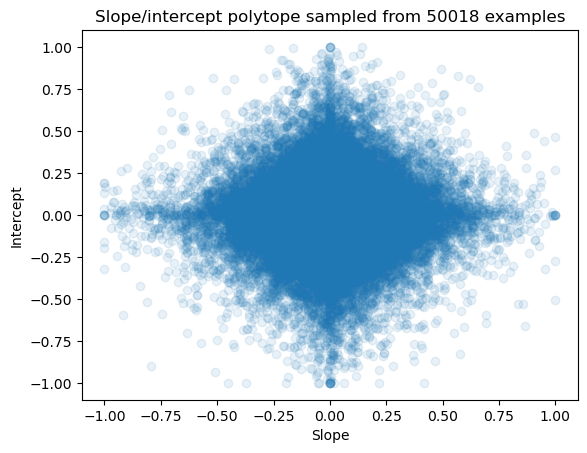

In [47]:
# Visualize the data we've generated
plt.scatter(*y.T, alpha=0.1)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title(f'Slope/intercept polytope sampled from {len(y)} examples')
plt.show()